In [3]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))

from heatflux_functions import * 

from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.casedeck import*
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *
from hermes3.selectors import *

# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def guard_replace_1d(da):
        """
        Replace the inner guard cells with the values of their respective
        cell edges, i.e. the values at the model inlet and at the target.
        This is done by interpolating the value between the two neighbouring
        cell centres.

        Cell order at target:
        ... | last | guard | second guard (unused)
                   ^target      
            |  -3  |  -2   |      -1
          
        Returns
        ----------
        - Guard replaced dataarray

        """


        # da[{"pos" : -2}] = (da[{"pos" : -2}] + da[{"pos" : -3}])/2
        # da[{"pos" : 1}] = (da[{"pos" : 1}] + da[{"pos" : 2}])/2
        
        da[-2] = (da[-2] + da[-3])/2
        da[1] = (da[1] + da[2])/2

        return da

In [5]:
sh = Load.case_1D(f'/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2025_04_snb_test/new_recycle_test_sh', guard_replace = False, use_squash=True)
snb = Load.case_1D(f'/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2025_04_snb_test/new_recycle_test_snb', guard_replace = False, use_squash=True)
old_snb = Load.case_1D(f'/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2024-03-25_wigram_reference_glover_comparison_FINAL_restart_selective_collisions/alpha_snb/neon_0.0', guard_replace = False, use_squash=True)

- Looking for squash file
- Squash file found. squash date 04/07/2025, 13:41:16, dmp file date 04/07/2025, 13:31:52
Skipping unnormalisation
- Looking for squash file
- Squash file found. squash date 04/07/2025, 13:58:46, dmp file date 04/07/2025, 13:01:12
Skipping unnormalisation
- Looking for squash file
- Squash file found. squash date 03/31/2025, 17:07:28, dmp file date 01/18/2025, 17:28:25
Skipping unnormalisation


In [6]:
for i in snb.ds.data_vars:
    print(i)

Bxy
Div_Q_SH
Div_Q_SNB
Ed+_iz
Ed+_rec
Ed_target_recycle
Edd+_cx
Fd+_iz
Fd+_rec
Fdd+_cx
G1
G2
G3
J
Kd+_cond
Kd_cond
Kdd+_cx
NVd
NVd+
Nd
Nd+
Ne
Pd
Pd+
Pd+_src
Pd_src
Pe
Pe_src
Rd+_ex
Rd+_rec
SNVd
SNVd+
SNd
SNd+
SPd
SPd+
SPe
Sd+_feedback
Sd+_iz
Sd+_rec
Sd+_src
Sd_src
Sd_target_recycle
Td
Td+
Te
Vd
Vd+
Ve
ddt(NVd)
ddt(NVd+)
ddt(Nd)
ddt(Nd+)
ddt(Pd)
ddt(Pd+)
ddt(Pe)
density_feedback_src_i_d+
density_feedback_src_mult_d+
density_feedback_src_p_d+
density_feedback_src_shape_d+
div_cond_par_d
div_cond_par_d+
efd+_cond_ylow
efd+_kin_ylow
efd+_tot_ylow
efd_cond_ylow
efd_kin_ylow
efd_tot_ylow
efe_kin_ylow
efe_tot_ylow
g11
g12
g13
g22
g23
g33
g_11
g_12
g_13
g_22
g_23
g_33
kappa_par_d
kappa_par_d+
pfd+_tot_ylow
pfd_tot_ylow
ncalls
ncalls_e
ncalls_i
t_array
da
dv


In [7]:
import scipy.integrate
def divq_integrate(dataframe, snb_int = False):
    """
    Calculate the total heat flux from the divergence of the Spitzer-Harm fluxes.
    If snb == True outputs integral of divq_snb, otherwise outputs integral of divq_sh.
    """

    x = np.ravel(dataframe['y'].values)[1:-1]
    Te = np.ravel(dataframe['Te'].values)


    div_q_snb = guard_replace_1d(np.ravel(dataframe['Div_Q_SNB'].values))[1:-1]
    div_q_sh = guard_replace_1d(np.ravel(dataframe['Div_Q_SH'].values))[1:-1]

    q_snb = scipy.integrate.cumulative_trapezoid(div_q_snb, x, initial=0)
    q_sh = scipy.integrate.cumulative_trapezoid(div_q_sh, x, initial=0)

    if snb_int == False:
        return q_sh
    else:
        return q_snb

In [8]:
snb_q = divq_integrate(snb.ds.isel(t = -1),snb_int = True)
# print(snb_q)

old_snb_q = divq_integrate(old_snb.ds.isel(t = -1),snb_int = True)

sh_q = divq_integrate(snb.ds.isel(t = -1),snb_int = False)

In [9]:
print(snb.ds.isel(t = -1)['Div_Q_SNB'].values)


[            nan  3.63453228e+06  3.78829003e+06  3.76815241e+06
  3.71757016e+06  3.72058936e+06  3.72131602e+06  3.72064646e+06
  3.72077203e+06  3.72125668e+06  3.72171008e+06  3.72207763e+06
  3.72238864e+06  3.72266905e+06  3.72293566e+06  3.72319922e+06
  3.72346611e+06  3.72373986e+06  3.72402226e+06  3.72431407e+06
  3.72461550e+06  3.72492649e+06  3.72524687e+06  3.72557647e+06
  3.72591513e+06  3.72626271e+06  3.72661901e+06  3.72698373e+06
  3.72735644e+06  3.72773664e+06  3.72812378e+06  3.72851733e+06
  3.72891677e+06  3.72932160e+06  3.72973130e+06  3.73014531e+06
  3.73056302e+06  3.73098376e+06  3.73140681e+06  3.73183145e+06
  3.73225694e+06  3.73268250e+06  3.73310728e+06  3.73353032e+06
  3.73395058e+06  3.73436693e+06  3.73477817e+06  3.73518314e+06
  3.73558067e+06  3.73596958e+06  3.73634858e+06  3.73671618e+06
  3.73707058e+06  3.73740965e+06  3.73773095e+06  3.73803176e+06
  3.73830909e+06  3.73855958e+06  3.73877931e+06  3.73896351e+06
  3.73910616e+06  3.73919

5.19e+07 W/m^2


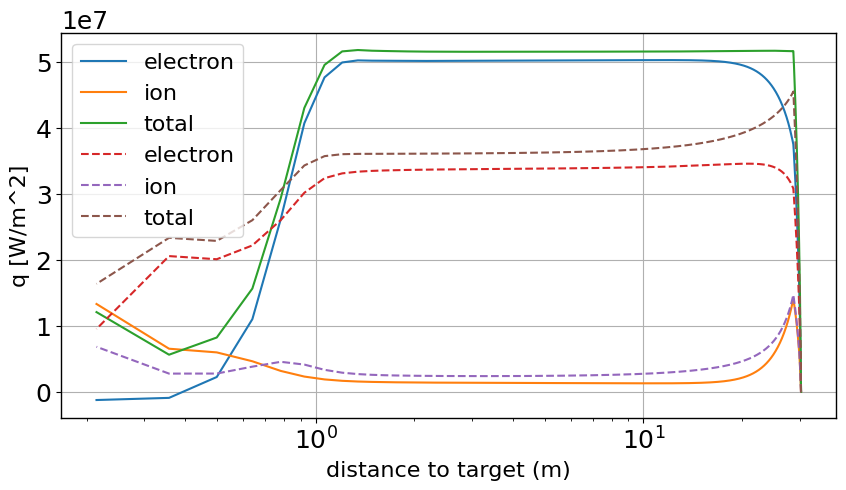

In [16]:
# sh.ds['efe_tot_ylow'].isel(t= -1).plot()

# snb.ds['efe_tot_ylow'].isel(t = -1).plot()


snb_ds = snb.ds.isel(t = -1)
sh_ds = sh.ds.isel(t = -1)
old_snb_ds = old_snb.ds.isel(t = -1)

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.set_xlabel('distance to target (m)')
ax.set_ylabel('q [W/m^2]')

total_q = (snb_ds['efd+_tot_ylow']/snb_ds['da'])[1:-1] + snb_q

ax.plot(snb_ds['y'][::-1][1:-1], snb_q, label = 'electron')
ax.plot(snb_ds['y'][::-1][1:-1], (snb_ds['efd+_tot_ylow']/snb_ds['da'])[1:-1], label = 'ion')
ax.plot(snb_ds['y'][::-1][1:-1], (snb_ds['efd+_tot_ylow']/snb_ds['da'])[1:-1] + snb_q, label = 'total')

ax.plot(snb_ds['y'][::-1][1:-1], (sh_ds['efe_tot_ylow']/sh_ds['da'])[1:-1], label = 'electron', linestyle = '--')
ax.plot(snb_ds['y'][::-1][1:-1], (sh_ds['efd+_tot_ylow']/sh_ds['da'])[1:-1], label = 'ion', linestyle = '--')
ax.plot(snb_ds['y'][::-1][1:-1], (sh_ds['efe_tot_ylow']/sh_ds['da'])[1:-1] +(sh_ds['efd+_tot_ylow']/sh_ds['da'])[1:-1] , label = 'total', linestyle = '--')



ax.legend()
print(f'{np.max(total_q):.2e} W/m^2')
# plt.gca().invert_xaxis()
ax.set_xscale('log')

# plt.plot(old_snb_ds['y'][1:-1], old_snb_q, label = 'old snb')
# plt.plot(snb_ds['y'], sh_q, label = 'sh')

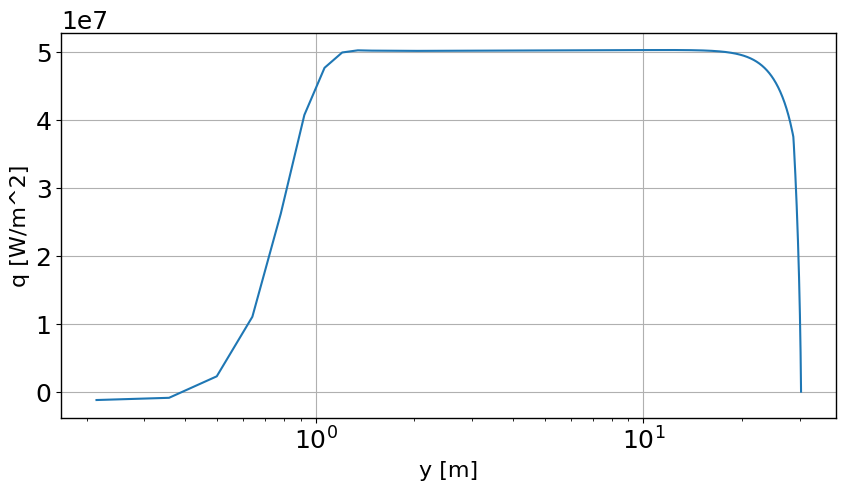

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.set_xlabel('y [m]')
ax.set_ylabel('q [W/m^2]')


ax.plot(snb_ds['y'][::-1][1:-1], snb_q, label = 'electron')
ax.set_xscale('log')
# ax.plot(old_snb_ds['y'][1:-1], (old_snb_ds['efd+_tot_ylow']/old_snb_ds['da'])[1:-1], label = 'old snb')

# New single proc iter runs

In [12]:

# alpha_vals = [-1, 0.2, 0.06, 'snb']
alpha_vals = [-1]

# neon_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
neon_vals = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

parent_dir = '/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/updated_flux_limitation/2025-04_single_core_production'


cs = dict()


for alpha in alpha_vals:
    for neon in neon_vals:
        name = f"alpha_{alpha}_neon_{neon}"
        print(f"Loading {name}")
        cs[name] = Load.case_1D(f'{parent_dir}/alpha_{alpha}/neon_{neon}', guard_replace = False, use_squash=True)


Loading alpha_-1_neon_0.0
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:01:46, dmp file date 04/09/2025, 18:51:54
Skipping unnormalisation
Loading alpha_-1_neon_0.01
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:02:09, dmp file date 04/09/2025, 19:38:34
Skipping unnormalisation
Loading alpha_-1_neon_0.02
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:02:40, dmp file date 04/09/2025, 20:49:21
Skipping unnormalisation
Loading alpha_-1_neon_0.03
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:03:04, dmp file date 04/09/2025, 22:04:49
Skipping unnormalisation
Loading alpha_-1_neon_0.04
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:03:25, dmp file date 04/09/2025, 23:35:15
Skipping unnormalisation
Loading alpha_-1_neon_0.05
- Looking for squash file
- Squash file found. squash date 04/10/2025, 12:03:44, dmp file date 04/10/2025, 01:29:24
Skipping unnormali

In [13]:
print(cs.keys())

dict_keys(['alpha_-1_neon_0.0', 'alpha_-1_neon_0.01', 'alpha_-1_neon_0.02', 'alpha_-1_neon_0.03', 'alpha_-1_neon_0.04', 'alpha_-1_neon_0.05', 'alpha_-1_neon_0.06'])


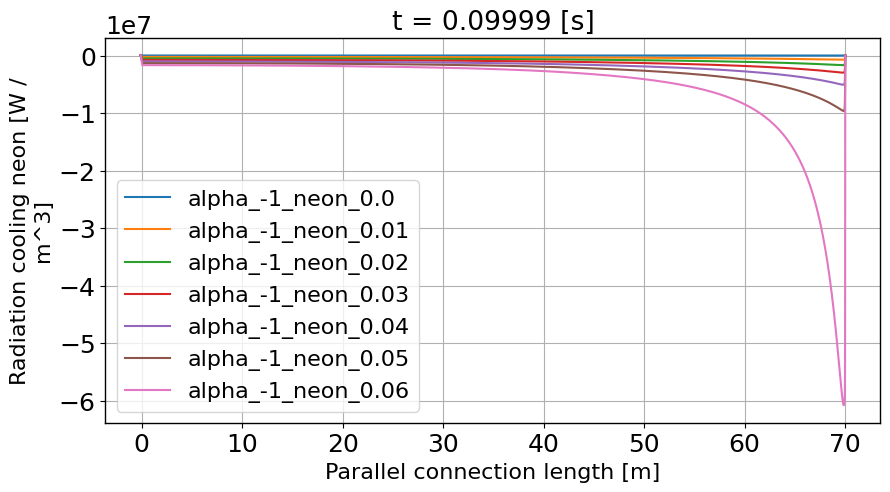

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
for i in cs.keys():
    cs[i].ds.isel(t = -1)['Rneon'][1:-1].plot(ax=ax,label = i)

# ax.set_xlabel('y [m]')
# ax.set_ylabel('Te [eV]')
ax.legend()
